# Step 1: Load the Data

In [88]:
import tensorflow as tf
import numpy as np

In [89]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10_000)

In [90]:
train_data.shape, test_data.shape

((25000,), (25000,))

In [91]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [92]:
def convert_to_english(list_of_integers):
  word_index = tf.keras.datasets.imdb.get_word_index()
  # reverse the word index
  reverse_word_index = {idx : word for (word, idx) in word_index.items() }
  # map each integer to a word and join all words together
  # Index 0, 1 and 2 are reserved for 'padding', 'start of sequence', and 'unknown'
  return " ".join(reverse_word_index.get(idx - 3, "?") for idx in list_of_integers)

# Step 2: Convert the Data

In [93]:
def convert_to_multi_hot(sequences, dimension):
  output = np.zeros(shape=(sequences.shape[0], dimension), dtype=np.float32)

  for idx, item in enumerate(sequences):
    output[idx, item] = 1.0

  return output

In [94]:
convert_to_multi_hot(np.array([[1,2,3,1],[0,4,5,4]]), dimension=6)

array([[0., 1., 1., 1., 0., 0.],
       [1., 0., 0., 0., 1., 1.]], dtype=float32)

In [95]:
X_train = convert_to_multi_hot(train_data, dimension=10_000)
X_test = convert_to_multi_hot(test_data, dimension=10_000)
# Rename the labels
y_train = train_labels
y_test = test_labels

In [96]:
X_val = X_test[:10_000]
y_val = y_test[:10_000]
X_test = X_test[-15_000:]
y_test = y_test[-15_000:]

In [97]:
X_train[0].shape

(10000,)

# Step 3: Build a Model

In [ ]:
def get_model():
  model = tf.keras.Sequential([
      tf.keras.Input(shape=(10_000,)),
      tf.keras.layers.Dense(units=16, activation="relu"),
      tf.keras.layers.Dense(units=16, activation="relu"),
      tf.keras.layers.Dense(units=1, activation="sigmoid")
  ])

  return model

In [ ]:
model = get_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160305 (626.19 KB)
Trainable params: 160305 (626.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Step 4: Compile the Model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss="binary_crossentropy", metrics="accuracy")

# Step 5: Train the Model

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=512, epochs=10)

Epoch 1/10
49/49 [==============================] - 3s 50ms/step - loss: 0.4753 - accuracy: 0.8144 - val_loss: 0.3500 - val_accuracy: 0.8774
Epoch 2/10
49/49 [==============================] - 3s 68ms/step - loss: 0.2777 - accuracy: 0.9012 - val_loss: 0.2889 - val_accuracy: 0.8875
Epoch 3/10
49/49 [==============================] - 2s 34ms/step - loss: 0.2177 - accuracy: 0.9195 - val_loss: 0.2997 - val_accuracy: 0.8814
Epoch 4/10
49/49 [==============================] - 2s 34ms/step - loss: 0.1836 - accuracy: 0.9331 - val_loss: 0.2838 - val_accuracy: 0.8869
Epoch 5/10
49/49 [==============================] - 2s 48ms/step - loss: 0.1622 - accuracy: 0.9421 - val_loss: 0.3005 - val_accuracy: 0.8827
Epoch 6/10
49/49 [==============================] - 3s 51ms/step - loss: 0.1443 - accuracy: 0.9501 - val_loss: 0.3378 - val_accuracy: 0.8749
Epoch 7/10
49/49 [==============================] - 2s 34ms/step - loss: 0.1298 - accuracy: 0.9546 - val_loss: 0.3275 - val_accuracy: 0.8793
Epoch 8/10
49

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
  plt.figure(figsize=(8, 5))
  for key, style in zip(history.history, ["r-o", "r-*", "b-o", "b-*"]):
    epochs = np.array(history.epoch)
    plt.plot(epochs + 1, history.history [key], style, label=key)
  plt.xlabel("Epoch")
  plt.axis([1, len(history.history['loss']), 0., 1])
  plt.legend(loc="lower left")
  plt.grid()

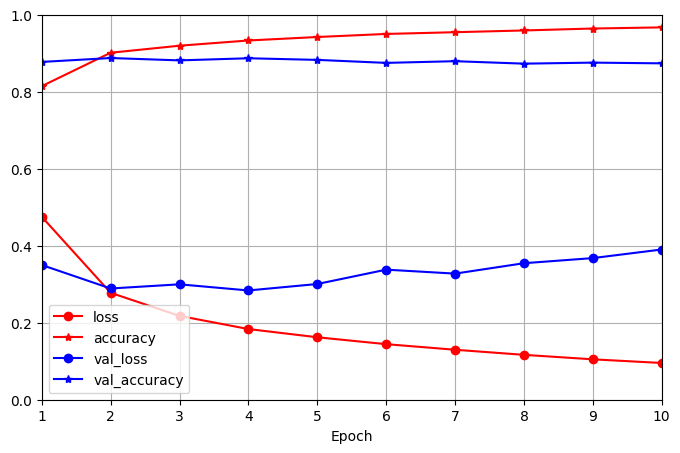

In [ ]:
plot_learning_curves(history=history)

# Step 6: Evaluate the Model

In [ ]:
model.evaluate(X_test, y_test)

469/469 [==============================] - 2s 5ms/step - loss: 0.3882 - accuracy: 0.8737


[0.388211190700531, 0.8736666440963745]

In [ ]:
def find_confidently_wrong(y_true, y_pred, top=10):
  """
  y_true: the true labels (0/1). Shape (n, 1)
  y_pred: the predictions (floats). Shape(n, 1)

  Returns: list of indices, such that these indices have the highest loss
  (and they are actually misclassified)
  """
  assert len(y_true.shape) == len(y_pred.shape) == 2, "Rank should be 2"
  assert y_true.shape [0] == y_pred.shape[0], "Not the same length"
  assert y_true.shape [1] == y_pred.shape[1] == 1, "Second dimension should be 1"

  bce = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

  losses = bce(y_true, y_pred).numpy()
  return np.argsort(losses)[-top:][::-1]

In [ ]:
y_test[0]

1

In [ ]:
y_test_true = y_test.reshape(-1, 1)
y_test_true[0]

array([1])

In [ ]:
y_test_pred = model.predict(X_test)

469/469 [==============================] - 1s 3ms/step


In [ ]:
y_test_pred

array([[0.97400516],
       [0.99983954],
       [0.00194443],
       ...,
       [0.10790838],
       [0.0408331 ],
       [0.9181325 ]], dtype=float32)

In [ ]:
find_confidently_wrong(y_test_true, y_test_pred)

array([14231,  5727,  6075,   227,   371,  2300,   596,  3988,   523,
        1146])

In [ ]:
import pprint

y_test_true = y_test.reshape(-1,1)
for idx in find_confidently_wrong(y_test_true, y_test_pred, top=10):
  actual_sentiment = 'POSITIVE' if y_test_true[idx][0] == 1 else 'NEGATIVE'
  predicted_sentiment = 'POSITIVE' if y_test_pred[idx][0] > 0.5 else 'NEGATIVE'
  # Add 10_000 because we used the first 10_000 elements as validation data
  pprint.pprint(convert_to_english(test_data [10_000 + idx]), width=80)
  print(f"is a {actual_sentiment} review but is was classified as {predicted_sentiment}.")
  print("*****************************************************")

1641221/1641221 [==============================] - 0s 0us/step
('? mickey rourke ? diane lane in ? ? ? it is not like mickey rourke ever '
 'really disappeared he has had a steady string of appearances before he burst '
 'back on the scene he was memorable in domino sin city man on fire once upon '
 'a time in mexico and get carter but in his powerful dramatic performance in '
 'the wrestler 2008 we see a full blown presentation of the character only '
 'hinted at in get carter whenever we get to know him rourke remains a cool '
 'but sleazy muscle bound slim ball br br this is an ? leonard story and '
 'production leonard wrote such notable movies as ? western thriller 3 10 to ? '
 'be cool jackie brown get ? ? pick up and joe ? this means that we get tough '
 'guys some good some not so good br br it also means we get tight realistic '
 'plots with characters doing what is best for them in each situation ? '
 'complications into violent conclusions ? is no different tough slim ball '